##### Lab - Collaborative Recommender System

In this lab you will implement the collaborative ﬁltering learning algorithm and apply it to a dataset of movie ratings. 

MovieLens 100k Dataset from GroupLens Research (https://grouplens.org/datasets/movielens/). 

This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u$ = 943 users, and
$n_m$ = 1682 movies. 

In [81]:
#Load relevant libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import pandas as pd

  ## Load the data
Load the matrices $Y$ and $R$ from matlab file *ex8_movies.mat*. 
 
$Y$ (*num_movies × num_users*)  stores the ratings $y^{(i,j)}$
(from 1 to 5). 

$R$ is an binary-valued indicator matrix (the same dimension as Y), where $R(i, j)$ = 1 if user $j$ gave a rating to movie $i$, and $R(i, j)$ = 0 otherwise. 

The objective of collaborative ﬁltering is to predict movie ratings for the movies
that users have not yet rated, that is, the entries with $R(i, j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.

In [82]:
from scipy.io import loadmat

# Load Y and R
data = loadmat('ex8_movies.mat')
# if Y[i,j] = 0, it means user j did not rate movie i.

Y = data['Y'] # Utility matrix, contain ratings (1-5) of movies given by users
R = data['R'] # Binary matrix, R(i,j) = 1 if user j give rating to movie i.

# What are the shapes of Y and  R and what is their meaning ?

print("Shape of Y:", Y.shape)  # e.g., (1682, 943)
print("Shape of R:", R.shape)  # e.g., (1682, 943)

Shape of Y: (1682, 943)
Shape of R: (1682, 943)


In [83]:
# How many users gave a score for the first movie ? ANSWER = 452
num_users_movie1 = R[0].sum()
print("Users who rated the first movie:", int(num_users_movie1))  # ANSWER: 452

# how many users gave a score for the second movie ? ANSWER= 131
num_users_movie2 = R[1].sum()
print("Users who rated the second movie:", int(num_users_movie2))  # ANSWER: 131

 # How many users gave a score for the last movie ? ANSWER = 1 
num_users_last_movie = R[-1].sum()
print("Users who rated the last movie:", int(num_users_last_movie))  # ANSWER: 1

Users who rated the first movie: 452
Users who rated the second movie: 131
Users who rated the last movie: 1


In [84]:
#Compute the average movie rating for the ﬁrst movie (Toy Story). ANSWER: 3.88
movie1_ratings = Y[0, R[0] == 1]

# Compute the average
average_rating_movie1 = movie1_ratings.mean()
print("Average rating for the first movie (Toy Story):", round(average_rating_movie1, 1))  # ANSWER: 3.88


Average rating for the first movie (Toy Story): 3.9


### Collaborative Filtering Learning Algorithm

The collaborative ﬁltering algorithm for movie recommendations considers that the movies have features, for example x1=romance, x2=action, x3=comedy, etc. In general the movies have $n$ different features, represented as a set of n-dimensional feature vectors X= $[ x^{(1)},... x^{(n_m)}] $. 

The model that will predict what is the rating $y(i,j)$ for movie $i$ given by user $j$   is formulated as a Linear Regression between the movie features and the user parameters θ= $[ θ^{(1)}, ...,θ^{(n_u)}] $, that is 

$ y(i,j)=(θ^{(j)})^{T}x^{(i)}$ =>  **Linear Regression model for computing the scores for movie $i$ given by user $j$**

Given a dataset of ratings produced
by **some users on some movies**, the model will try to learn simultaneously both vectors  

 X=$ [x^{(1)},... x^{(n_m)}]$ and θ=$[θ^{(1)}, ...,θ^{(n_u)}]$
 
 that produce the best ﬁt (minimize the
error between the predictions $y(i,j)$ and the real scores given by the users).


**The collaborative filtering cost function with regularization terms is given by**

$J(x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_u)}) = \frac{1}{2} \sum_{((i,j): r(i,j)=1)}((\theta^{(j)})^Tx^{(i)} - y^{(i,j)})^2 + (\frac{\lambda}{2} \sum^{n_u}_{j=1}\sum^n_{k=1} (\theta^{(j)}_k)^2) + (\frac{\lambda}{2} \sum^{n_m}_{i=1}\sum^n_{k=1} (x^{(i)}_k)^2)$

**The collaborative filtering gradients of the cost function $J$ (with regularization) are given by**

$\frac{\partial J}{\partial x^{(i)}_k} = \sum ((\theta^{(j)})^Tx^{(i)} - y^{(i,j)})\theta_k^{(j)} +\lambda x^{(i)}_k$

$\frac{\partial J}{\partial \theta^{(j)}_k} = \sum ((\theta^{(j)})^Tx^{(i)} - y^{(i,j)})x_k^{(i)} +\lambda \theta^{(j)}_k$

In [85]:
def  cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda):
    """
    Returns the cost and gradient for the collaborative filtering
    Lambda - regularization parameter
    
    """
        
    # Unfold the params
    X = params[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = params[num_movies*num_features:].reshape(num_users,num_features)
    
    predictions =  X @ Theta.T
    err = (predictions - Y)
    J = 1/2 * np.sum((err**2) * R)
    
    #compute regularized cost function
    reg_X =  Lambda/2 * np.sum(Theta**2)
    reg_Theta = Lambda/2 *np.sum(X**2)
    reg_J = J + reg_X + reg_Theta
    
    # Compute gradient
    X_grad = err*R @ Theta
    Theta_grad = (err*R).T @ X
    grad = np.append(X_grad.flatten(),Theta_grad.flatten())
    
    # Compute regularized gradient
    reg_X_grad = X_grad + Lambda*X
    reg_Theta_grad = Theta_grad + Lambda*Theta
    reg_grad = np.append(reg_X_grad.flatten(),reg_Theta_grad.flatten())
    
    return J, grad, reg_J, reg_grad

In function *cofiCostFunc*: 
 
$X$ (num_movies × n) is the matrix of movie features (also called movie parameters), $n$ is the number of features,  $i$ row of $X$ corresponds to the feature vector $x^{(i)}$ of the $i$ movie.

$θ$ (num_users × n) is the matrix of user parameters, $j$ row of $θ$ corresponds to the parameter vector $θ^{(j)}$, of the $j$ user. 

Both $x^{(i)}$ and $θ^{(j)}$ are n-dimensional vectors, $x^{(i)} ∈ R^{n}$ and $θ^{(j)}∈R^{n}$ .

$X$ and $θ$ will be inicialized randomly, however, in order to test the *cofiCostFunc* function, we have saved some parameters $X$ and $θ$ in the matlab file *ex8_movieParams.mat*. 


In [86]:
from scipy.io import loadmat
import numpy as np

#Load X and Theta from ex8_movieParams.mat and print their dimensions. 
data = loadmat('ex8_movieParams.mat')

X = data['X']
Theta = data['Theta']

#How many features have the movies ?
print("Shape of X (num_movies, num_features):", X.shape)
print("Shape of Theta (num_users, num_features):", Theta.shape)

num_features = X.shape[1]
print("Number of features for each movie:", num_features)


Shape of X (num_movies, num_features): (1682, 10)
Shape of Theta (num_users, num_features): (943, 10)
Number of features for each movie: 10


In [87]:
# In order to speed up the test, data set size is reduced 
num_users, num_movies, num_features = 4,5,3

#Extract from X, Theta, Y, and R only data coresponding to 
#the new number of users, number of movies, number of features 

X_test = X[:num_movies, :num_features]
Theta_test = Theta[:num_users, :num_features]
Y_test = Y[:num_movies, :num_users]
R_test = R[:num_movies, :num_users]

# Due to the simultaneous optimization of X and Theta, 
#all elements of X and Theta are flattened and appended into a single vector

params = np.append(X_test.flatten(),Theta_test.flatten())

# Compute the cost function (without regularization).  ANSWER: J=22.22
J, grad, reg_J, reg_grad = cofiCostFunc(params, Y_test, R_test, num_users, num_movies, num_features, Lambda=0)
print("Cost at loaded parameters (lambda = 0):", round(J, 2))

# Compute the cost function (with regularization). ANSWER: J=31.34
J, grad, reg_J, reg_grad = cofiCostFunc(params, Y_test, R_test, num_users, num_movies, num_features, Lambda=1.5)
print("Cost at loaded parameters (lambda = 1.5):", round(reg_J, 2))

Cost at loaded parameters (lambda = 0): 22.22
Cost at loaded parameters (lambda = 1.5): 31.34


### Data set of MOVIES 

The list of all movies and their index in the dataset are listed in the ﬁle *movie_idx.txt*

In [88]:
# load the movie list
#movieList = open("movie_ids.txt","r").read().split("\n")[:-1]

#for Linux / UNix users
movieList = open("movie_ids.txt","r", encoding='ISO-8859-1').read().split("\n")[:-1]

#How many movies are collected ?
num_movies = len(movieList)
print(f"Number of movies collected: {num_movies}")

# show the movies in the list
print("Movies in the list:")
for movie in movieList:
    print(movie)

Number of movies collected: 1682
Movies in the list:
1 Toy Story (1995)
2 GoldenEye (1995)
3 Four Rooms (1995)
4 Get Shorty (1995)
5 Copycat (1995)
6 Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)
7 Twelve Monkeys (1995)
8 Babe (1995)
9 Dead Man Walking (1995)
10 Richard III (1995)
11 Seven (Se7en) (1995)
12 Usual Suspects, The (1995)
13 Mighty Aphrodite (1995)
14 Postino, Il (1994)
15 Mr. Holland's Opus (1995)
16 French Twist (Gazon maudit) (1995)
17 From Dusk Till Dawn (1996)
18 White Balloon, The (1995)
19 Antonia's Line (1995)
20 Angels and Insects (1995)
21 Muppet Treasure Island (1996)
22 Braveheart (1995)
23 Taxi Driver (1976)
24 Rumble in the Bronx (1995)
25 Birdcage, The (1996)
26 Brothers McMullen, The (1995)
27 Bad Boys (1995)
28 Apollo 13 (1995)
29 Batman Forever (1995)
30 Belle de jour (1967)
31 Crimson Tide (1995)
32 Crumb (1994)
33 Desperado (1995)
34 Doom Generation, The (1995)
35 Free Willy 2: The Adventure Home (1995)
36 Mad Love (1995)
37 Nadja (1994)
38 Net, T

### Give your own preferences  for some of the movies 
We have ﬁlled out some values according to our own preferences, but you can enter your own movie preferences, so that later when the algorithm runs, you can get your own movie recommendations!

In [89]:
# Initialize my ratings
my_ratings = np.zeros((num_movies,1))

# Create own ratings
my_ratings[0] = 4 
my_ratings[97] = 2
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63]= 5
my_ratings[65]= 3
my_ratings[68] = 5
my_ratings[82]= 4
my_ratings[225] = 5
my_ratings[354]= 5

print("New user ratings:\n")
for i in range(len(my_ratings)):
    if my_ratings[i]>0:
        print("Rated",int(my_ratings[i]),"for index",movieList[i])

New user ratings:

Rated 4 for index 1 Toy Story (1995)
Rated 3 for index 7 Twelve Monkeys (1995)
Rated 5 for index 12 Usual Suspects, The (1995)
Rated 4 for index 54 Outbreak (1995)
Rated 5 for index 64 Shawshank Redemption, The (1994)
Rated 3 for index 66 While You Were Sleeping (1995)
Rated 5 for index 69 Forrest Gump (1994)
Rated 4 for index 83 Much Ado About Nothing (1993)
Rated 2 for index 98 Silence of the Lambs, The (1991)
Rated 5 for index 226 Die Hard 2 (1990)
Rated 5 for index 355 Sphere (1998)


/tmp/ipykernel_8751/3024420690.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Rated",int(my_ratings[i]),"for index",movieList[i])


Add the additional ratings in the original dataset Y and R

In [90]:
num_users_before = Y.shape[1]

Y = np.hstack((my_ratings,Y))
R = np.hstack((my_ratings!=0,R))

#Confirm that the number of users increased by one
num_users_after = Y.shape[1]

print(f"Number of users before: {num_users_before}")
print(f"Number of users after: {num_users_after}")

Number of users before: 943
Number of users after: 944


### Learning movie recommendations

Normalize the ratings Y. 

Generate random initial values for X and Theta. 

Call Gradient Descent to optimize X and Theta. 

In [91]:
def normalizeRatings(Y, R):
    """
    normalized Y so that each movie has a rating of 0 on average, and returns the 
    mean rating in Ymean.
    """
  
    m = Y.shape[0]  # number of movies
    n = Y.shape[1]  # number of users
    
    #Inicialize Ymean as column vector of 0 with m elements 
    #Inicialize Ynorm as matrix with the same dimenssion as Y 
    Ymean = np.zeros(m)
    Ynorm = np.zeros_like(Y)
    
    for i in range(m):
        Ymean[i] = np.sum(Y[i,:])/np.count_nonzero(R[i,:])
        Ynorm[i,R[i,:]==1] = Y[i,R[i,:]==1] - Ymean[i]
        
    return Ynorm, Ymean

In [92]:
def gradientDescent(initial_parameters,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda):
    """
    alpha - learning rate
    Optimize X and Theta
    """
    # unfold the initial parameters (consult function cofiCostFunc)
    X = initial_parameters[:num_movies * num_features].reshape(num_movies, num_features)
    Theta = initial_parameters[num_movies * num_features:].reshape(num_users, num_features)

    
    J_history =[]
    
    for i in range(num_iters):
        #Append into a single vector params X and Theta (see above)
        params = np.append(X.flatten(), Theta.flatten())

        
        cost, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda)[2:]
        
        # unfold grad
        gradX = grad[:num_movies*num_features].reshape(num_movies,num_features)
        gradTheta = grad[num_movies*num_features:].reshape(num_users,num_features)
        
#Update trainable parameters X & Theta applying gradient descent method
        X = X - alpha * gradX
        Theta = Theta - alpha * gradTheta
        
        J_history.append(cost)
    
    #Append into a single vector paramsFinal the updated X and Theta
    paramsFinal = np.append(X.flatten(), Theta.flatten())

    return paramsFinal , J_history

In [93]:
# Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

In [94]:
# number of users
num_users = Ynorm.shape[1]

# number of movies
num_movies = Ynorm.shape[0]

num_features = 10

# Generate randomly initial values for the matrices X and Theta 
#(use for example np.random.randn())
X = np.random.randn(num_movies, num_features)
Theta = np.random.randn(num_users, num_features)

#Append into a single vector params X and Theta 
initial_parameters = np.append(X.flatten(), Theta.flatten())

Lambda = 10

#Try different number of iterations until the cost function converge 
num_iters=400
alpha=0.001

# Optimize parameters using Gradient Descent, use the normalized Ynorm
paramsFinal, J_history = gradientDescent(initial_parameters, Ynorm, R, num_users, num_movies, num_features, alpha, num_iters, Lambda)

### Plot the cost Function

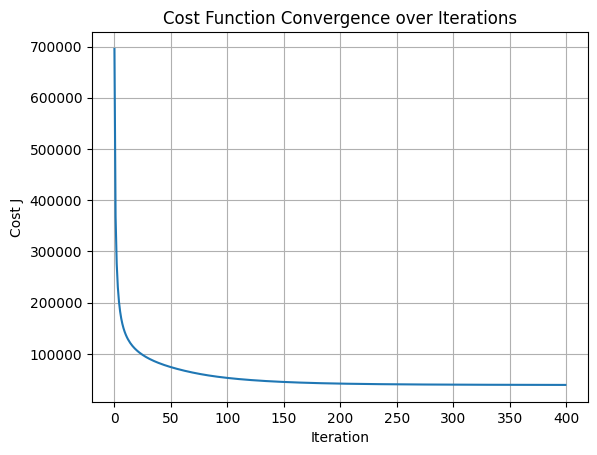

In [100]:
plt.plot(J_history)
plt.xlabel('Iteration')
plt.ylabel('Cost J')
plt.title('Cost Function Convergence over Iterations')
plt.grid(True)
plt.show()

In [97]:
#unfold paramsFinal (consult function cofiCostFunc)
X = paramsFinal[:num_movies * num_features].reshape(num_movies, num_features)
Theta = paramsFinal[num_movies * num_features:].reshape(num_users, num_features)

# Predict all ratings of num_users for num_movies
p = X @ Theta.T

# Extract from p only the recomendations for the added user
# Reshape because of rank one problem 

my_scores = p[:, 0].reshape(-1, 1)

my_predictions = my_scores + Ymean

In [98]:
df = pd.DataFrame(np.column_stack((my_predictions,np.array(movieList))))

df.sort_values(by=[0],ascending=False,inplace=True)
df.reset_index(drop=True,inplace=True)

#Extract only the top 10 recommented movies for the added user 
top_10_movies = df.head(10)
print(top_10_movies)

                0                   1                   2     \
0  4.245363127348371   3.572882801109387  3.4001092642137127   
1  4.181915515651925  3.5094351894129407  3.3366616525172663   
2  4.178184573136354  3.5057042468973707  3.3329307100016963   
3  4.170959651835741  3.4984793255967572  3.3257057887010824   
4  4.164049801714702   3.491569475475719  3.3187959385800445   
5  4.161352445993578  3.4888721197545944  3.3160985828589196   
6  4.155279577262649   3.482799251023666  3.3100257141279914   
7  4.153195120636889  3.4807147943979055   3.307941257502231   
8  4.146664664920553   3.474184338681569  3.3014108017858947   
9  4.142332440676605  3.4698521144376215   3.297078577541947   

                 3                   4                   5     \
0  3.9170151653301404  3.6691015122757284  3.9436990078034566   
1   3.853567553633694   3.605653900579282    3.88025139610701   
2   3.849836611118124   3.601922958063712    3.87652045359144   
3  3.8426116898175104  3.5946980367